In [2]:
import numpy as np
from numba import njit, prange
import arepo
import matplotlib.pyplot as plt

In [3]:
ics_dir = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/test_part/ics/'
lvl = 'lvl4'

In [4]:
ics = arepo.Snapshot(ics_dir + lvl + '/MW_ICs.dat')

In [5]:
@njit(parallel=True)
def Hernquist_force(pos, M, a, G):
    N = pos.shape[0]
    mGM = - G * M
    acc = np.zeros(pos.shape)
    for i in prange(N):
        r = np.sqrt(pos[i][0]*pos[i][0] + pos[i][1]*pos[i][1] + pos[i][2]*pos[i][2])
        acc[i][0] = mGM * pos[i][0] / (r * (a + r)**2)
        acc[i][1] = mGM * pos[i][1] / (r * (a + r)**2)
        acc[i][2] = mGM * pos[i][2] / (r * (a + r)**2)
        
    return acc

@njit(parallel=True)
def Hernquist_pot(pos, M, a, G):
    N = pos.shape[0]
    mGM = - G * M
    pot = np.zeros(N)
    for i in prange(N):
        r = np.sqrt(pos[i][0]*pos[i][0] + pos[i][1]*pos[i][1] + pos[i][2]*pos[i][2])
        pot[i] = mGM / (r + a)
        
    return pot

In [6]:
@njit
def _compute_phi_r(A, vc, r, rCR, b):
    ans = - A * vc**2 / 2
    ans *= (r/rCR)**2
    ans *= ((b+1.)/(b+r/rCR))**5.
    return ans

@njit
def _compute_partial_phi_r(A, vc, r, rCR, b):
    term1 = - A * vc**2 * (r/rCR)**2 * ((b+1)/(b+r/rCR))**5
    term2 = (-A*vc**2/2) * (5 * ((b+1)/(b+r/rCR))**4) * (-((b+1)*rCR)/(r+rCR)**2)
    
    return term1 + term2

@njit(parallel=True)
def bar_pot(pos, A, b, vc, ps, ang):
    N = pos.shape[0]
    pot = np.zeros(N)
    rCR = vc / ps
    for i in range(N):
        r = np.sqrt(pos[i][0]*pos[i][0] + pos[i][1]*pos[i][1] + pos[i][2]*pos[i][2])
        theta = np.arccos(pos[i][2]/r)
        phi = np.arctan2(pos[i][1], pos[i][0])
        
        phi_r = _compute_phi_r(A, vc, r, rCR, b)
        
        pot[i] = phi_r * np.sin(theta)**2 * np.cos(2.*(phi - ang))
    
    return pot

@njit(parallel=False)
def bar_force(pos, A, b, vc, ps, ang):
    acc = np.zeros(pos.shape)
    rCR = vc / ps
    N = pos.shape[0]
    # print('rCR= ', rCR)
    
    for i in range(N):
        
        r = np.sqrt(pos[i][0]*pos[i][0] + pos[i][1]*pos[i][1] + pos[i][2]*pos[i][2])
        
        # print(0)
        
        # if r==0:
            # print('r=0')
        
        theta = np.arccos(pos[i][2]/r)
        phi = np.arctan2(pos[i][1], pos[i][0])
        
        # if np.sin(theta)==0:
            # print('sin(theta) = 0')
        
        # print(r, theta, phi)
        
        # print(1)
        
        phi_r = _compute_phi_r(A, vc, r, rCR, b)
        
        acc_r = -(1./r) * ((2*b-3*r/rCR)/(b+r/rCR)) * phi_r
        # print(acc_r)
        acc_r = - _compute_partial_phi_r(A, vc, r, rCR, b)
        acc_r *= np.sin(theta)**2 * np.cos(2.*(phi - ang))
        
        # print(2)
        
        acc_theta = - phi_r * 2.*np.sin(theta)*np.cos(theta) * np.cos(2.*(phi-ang)) / r
        
        acc_phi = - phi_r * np.sin(theta) * (-2 * np.sin(2.*(phi-ang))) / r
        
        # print(3)
        
        # acc[i][0] = acc_r
        # acc[i][1] = acc_theta
        # acc[i][2] = acc_phi
        
        acc[i][0] = np.sin(theta)*np.cos(phi)*acc_r + np.cos(theta)*np.cos(phi)*acc_theta - np.sin(phi)*acc_phi
        acc[i][1] = np.sin(theta)*np.sin(phi)*acc_r + np.cos(theta)*np.sin(phi)*acc_theta + np.cos(phi)*acc_phi
        acc[i][2] = np.cos(theta) * acc_r - np.sin(theta) * acc_theta
        
    return acc

In [7]:
@njit(parallel=True)
def integrate_particles(pos, vel, mres, M, a, A, b, vc, ps, dt=0.1, Tmax=1.0,
                        torque_gas=20.0, I_at_rCR6=2.0, G=43007.1):
    T = 0.0
    
    ang = 0.0
    
    acc_halo = Hernquist_force(pos, M, a, G)
    acc_bar = bar_force(pos, A, b, vc, ps, ang)
    acc = acc_halo + acc_bar
#     pot = Hernquist_pot(pos, N, M, a, G)
    
    Nint = int(Tmax/dt)+1
    print('Nint=', Nint)
    init_ps = ps
    
    # Output arrays
    total_torque = np.zeros((Nint, 3))
    time_out = np.zeros(Nint)
    ps_out = np.zeros(Nint)
    
    for i in range(Nint):
        # Analysis
        torque = mres * np.cross(pos, acc)
        total_torque[i] = np.sum(torque, axis=0)
        ps_out[i] = ps
        time_out[i] = T

        # Print
        print('i=', i, ' T=', T, 'total_torque=', total_torque[i], 'ps=', ps)
        
        # First half-kick and drift
        for j in prange(N):
            for k in range(3):
                vel[j][k] += acc[j][k] * dt / 2.
                pos[j][k] += vel[j][k] * dt
        
        rCR = vc/ps
        I = I_at_rCR6 * (rCR/6.0)**2
        Lz_bar = I * ps
        
        ps += - total_torque[i][2]/I * dt / 2.0 # constant ps
        ps += torque_gas/I * dt / 2.0
        ang += ps * dt
        
        if np.any(np.isnan(pos)):
            print('nan')
            # print(pos[np.isnan(pos)])
        
        # Force computation
        acc_halo = Hernquist_force(pos, M, a, G)
        acc_bar = bar_force(pos, A, b, vc, ps, ang)
        # acc = acc_halo + acc_bar
        acc = acc_halo + acc_bar
        
#         pot = Hernquist_pot(pos, N, M, a, G)
        
        # Second half-kick
        for j in prange(N):
            for k in range(3):
                vel[j][k] += acc[j][k] * dt / 2.
        
        rCR = vc/ps
        I = 0.2 * (b*rCR)**2 * 1.25**2
        Lz_bar = I * ps
        
        ps += - Lz_bar/I* dt / 2.0 # constant ps
        ps += torque_gas/I * dt / 2.0
        
        T += dt
        
    
#     out = {'total_torque'}
    
    return time_out, total_torque, ps_out

In [12]:
M = 100.698
a = 26.2432

A = 0.02
b = 0.28
vc = 235
ps = 40

pos = np.copy(ics.part1.pos)
vel = np.copy(ics.part1.vel)
T = 0.0
N = ics.NumPart_Total[1]
mres = ics.MassTable[1]

acc_halo = Hernquist_force(pos, M, a, 43007.1)
# acc_bar = bar_force(pos, N, A, b, vc, ps, 0.0)



In [9]:
bar_force(pos, A, b, vc, ps, 0.0)

array([[ 6.29408573e-02, -1.19820130e+01,  3.86054077e+00],
       [ 3.96502165e+01, -1.13636867e+02, -8.22425970e+00],
       [ 3.38124212e-01,  9.42981754e-02, -3.20444840e-01],
       ...,
       [ 8.98868037e+00, -2.47635559e+00,  6.28554240e-01],
       [ 2.60292705e-04,  2.91839603e-02, -3.63743267e-03],
       [ 5.38968249e-03,  1.98883648e-02, -1.60137177e-02]])

In [10]:
bar_force(np.array([[0., 20., 0.], [20., 0., 0.]]), A, b, vc, ps, 0.0)

array([[-3.54287719e-15, -6.43386237e+01, -3.74124083e-15],
       [ 6.43386237e+01,  0.00000000e+00,  3.74124083e-15]])

In [11]:
Hernquist_force(np.array([[20., 0., 0.]]), M, a, 43007.1)

array([[-2025.18753197,    -0.        ,    -0.        ]])

In [12]:
%%time
acc = Hernquist_force(pos, M, a, 43007.1)

CPU times: user 76.3 ms, sys: 39 ms, total: 115 ms
Wall time: 119 ms


In [13]:
prange?

Init signature: prange(*args)
Docstring:     
Provides a 1D parallel iterator that generates a sequence of integers.
In non-parallel contexts, prange is identical to range.
File:           /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/numba/misc/special.py
Type:           type
Subclasses:     


In [16]:
%%time
time, torque, ps_out = integrate_particles(pos, vel, mres, M, a, A, b, vc, ps, dt=0.01, Tmax=2.0, I_at_rCR6=4.0, torque_gas=30.0)

Nint= 201
i= 0  T= 0.0 total_torque= [5.69212883 8.8641566  7.30241093] ps= 40.0
i= 1  T= 0.01 total_torque= [ 1.59818857 10.66177526 14.02308496] ps= 40.00708869394768
i= 2  T= 0.02 total_torque= [-3.91993421  7.77292058 38.25816464] ps= 40.005416186491445
i= 3  T= 0.03 total_torque= [-5.56227132  3.44876109 59.34595533] ps= 39.972007871376704
i= 4  T= 0.04 total_torque= [-5.30916306  5.72576925 67.93052635] ps= 39.91092770666167
i= 5  T= 0.05 total_torque= [ 6.92474916  0.80612354 59.21655511] ps= 39.83854445997605
i= 6  T= 0.060000000000000005 total_torque= [ 7.40282924 -4.94285009 61.7937188 ] ps= 39.77737551858398
i= 7  T= 0.07 total_torque= [ 12.3430573  -11.11316411  64.62592273] ps= 39.71275404625284
i= 8  T= 0.08 total_torque= [ 7.37909011  8.28072009 55.4903    ] ps= 39.64436689086738
i= 9  T= 0.09 total_torque= [-6.96724136 13.80465351 71.29278545] ps= 39.58761842013704
i= 10  T= 0.09999999999999999 total_torque= [-11.60995574  -3.30586894  66.74804604] ps= 39.51049333803973

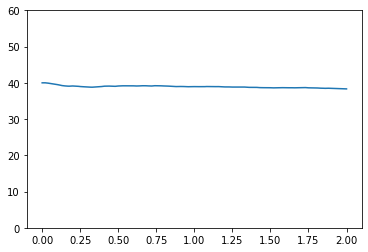

In [18]:
plt.plot(time, ps_out)
# plt.yscale('log')
plt.ylim(0, 60)
plt.show()

In [35]:
55.1/8.66

6.362586605080831

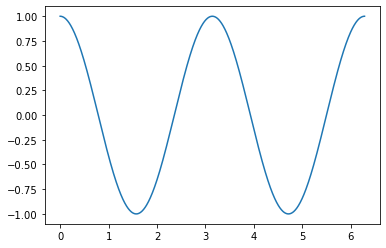

In [23]:
theta_list = np.linspace(0., 2.*np.pi, 1000)
y = np.cos(2.*theta_list)
plt.plot(theta_list, y)
plt.show()

In [5]:
@njit
def _compute_phi_r(A, vc, r, rCR, b):
    ans = - A * vc**2 / 2
    ans *= (r/rCR)**2
    ans *= ((b+1.)/(b+r/rCR))**5.
    return ans

@njit
def _compute_partial_phi_r(A, vc, r, rCR, b):
    term1 = - A * vc**2 * (r/rCR)**2 * ((b+1)/(b+r/rCR))**5
    term2 = (-A*vc**2/2) * (5 * ((b+1)/(b+r/rCR))**4) * (-((b+1)*rCR)/(r+rCR)**2)
    
    
    return term1 + term2

@njit(parallel=True)
def bar_pot(pos, N, A, b, vc, ps, ang):
    pot = np.zeros(N)
    rCR = vc / ps
    for i in range(N):
        r = np.sqrt(pos[i][0]*pos[i][0] + pos[i][1]*pos[i][1] + pos[i][2]*pos[i][2])
        theta = np.arccos(pos[i][2]/r)
        phi = np.arctan2(pos[i][1], pos[i][0])
        
        phi_r = _compute_phi_r(A, vc, r, rCR, b)
        
        pot[i] = phi_r * np.sin(theta)**2 * np.cos(2.*(phi - ang))
    
    return pot

@njit(parallel=True)
def bar_force(pos, N, A, b, vc, ps, ang):
    acc = np.zeros(pos.shape)
    rCR = vc / ps
    for i in range(N):
        r = np.sqrt(pos[i][0]*pos[i][0] + pos[i][1]*pos[i][1] + pos[i][2]*pos[i][2])
        theta = np.arccos(pos[i][2]/r)
        phi = np.arctan2(pos[i][1], pos[i][0])
        
        # print(r, theta, phi)
        
        phi_r = _compute_phi_r(A, vc, r, rCR, b)
        
        # acc_r = -(1./r) * ((2*b-3*r/rCR)/(b+r/rCR)) * phi_r
        # print(acc_r)
        acc_r = - _compute_partial_phi_r(A, vc, r, rCR, b)
        acc_r *= np.sin(theta)**2 * np.cos(2.*(phi - ang))
        
        acc_theta = - phi_r * 2.*np.sin(theta)*np.cos(theta) * np.cos(2.*(phi-ang)) / r
        
        acc_phi = - phi_r * np.sin(theta)**2 * (-2 * np.sin(2.*(phi-ang))) / (r * np.sin(theta))
        
        acc[i][0] = acc_r
        acc[i][1] = acc_theta
        acc[i][2] = acc_phi
        
        # acc[i][0] = np.sin(theta)*np.cos(phi)*acc_r + np.cos(theta)*np.cos(phi)*acc_theta - np.sin(phi)*acc_phi
        # acc[i][1] = np.sin(theta)*np.sin(phi)*acc_r + np.cos(theta)*np.sin(phi)*acc_theta + np.cos(phi)*acc_phi
        # acc[i][2] = np.cos(theta) * acc_r - np.sin(theta) * acc_theta
        
    return acc

In [6]:
A = 0.02
b = 0.28
vc = 235
ps = 40

In [7]:
r = 10.
bar_force(np.array([[r, 0., 0.], [0., r, 0.]]), 2, A, b, vc, ps, 0.0)

array([[ 3.45041126e+02,  2.20050608e-15, -0.00000000e+00],
       [-3.45041126e+02, -2.20050608e-15, -4.40101216e-15]])

In [8]:
nres = 256
grid = np.zeros((nres*nres, 3))
pts = np.linspace(-10, 10, nres)
for i in range(nres):
    for j in range(nres):
        grid[i + j*nres][0] = pts[i]
        grid[i + j*nres][1] = pts[j]

In [9]:
pot = bar_pot(grid, nres*nres, A, b, vc, ps, 0.0)
pot = np.reshape(pot, (nres, nres))

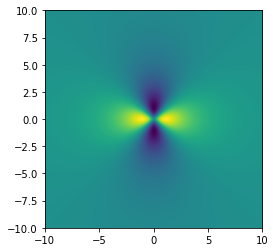

In [19]:
plt.imshow(pot.T, origin='lower', extent=[-10, 10, -10, 10])

In [61]:
acc = bar_force(grid, nres*nres, A, b, vc, ps, 0.0)
acc = np.reshape(acc, (nres, nres, 3))

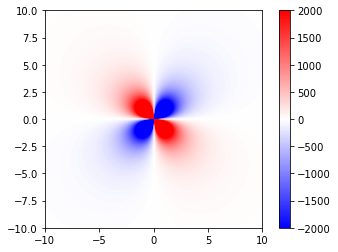

In [77]:
plt.imshow(acc[:,:,2].T, origin='lower', vmin=-2000, vmax=2000, extent=[-10, 10, -10, 10], cmap='bwr')
plt.colorbar()

In [20]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [21]:
sn = read_snap(500, 0, lvl='lvl3', parttype=[1])

In [35]:
from scipy.spatial import KDTree
import matplotlib as mpl

In [23]:
tree = KDTree(sn.part1.pos.value)

In [25]:
pos = sn.part1.pos.value
r = np.linalg.norm(pos, axis=1)
theta = np.arccos(pos[:,2]/r)
phi = np.arctan2(pos[:,1], pos[:,0])

acc = sn.part1.acce
acc_r = np.sin(theta)*np.cos(phi)*acc[:,0] + np.sin(theta)*np.sin(phi)*acc[:,1] + np.cos(theta)*acc[:,2]


In [30]:
_, tree_keys = tree.query(grid)


In [31]:
acc_grid = acc_r[tree_keys]

In [32]:
acc_grid = np.reshape(acc_grid, (nres, nres))

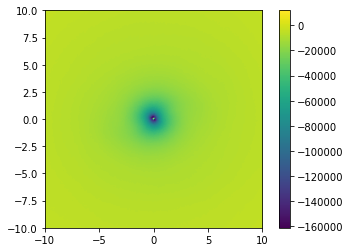

In [39]:
plt.imshow(acc_grid.T, origin='lower', extent=[-10, 10, -10, 10], vmin=-2000, vmax=2000, cmap='bwr')
plt.colorbar()

In [40]:
import h5py as h5
fname = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/analysis/torques/data/torques_Nbody-lvl3/'
fname = fname + 'torques_Nbody-lvl3.200.hdf5'
t = h5.File(fname, mode='r')

In [43]:
tree = KDTree(t['pos_halo'])

In [56]:
pos = np.array(t['pos_halo'])
acc = np.array(t['acc_halo'])

r = np.linalg.norm(pos, axis=1)
theta = np.arccos(pos[:,2]/r)
phi = np.arctan2(pos[:,1], pos[:,0])

acc_r = np.sin(theta)*np.cos(phi)*acc[:,0] + np.sin(theta)*np.sin(phi)*acc[:,1] + np.cos(theta)*acc[:,2]

In [57]:
_, tree_keys = tree.query(grid)


In [58]:
acc_grid = acc_r[tree_keys]
acc_grid = np.reshape(acc_grid, (nres, nres))

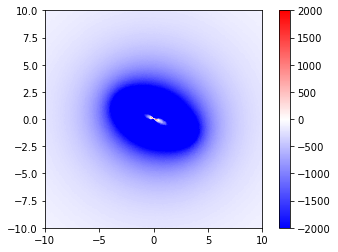

In [60]:
plt.imshow(acc_grid.T, origin='lower', extent=[-10, 10, -10, 10], vmin=-2000, vmax=2000, cmap='bwr')
plt.colorbar()

In [55]:
len(pos)

25347840

In [65]:
from galpy.potential import DehnenBarPotential

In [66]:
pot = DehnenBarPotential()

In [75]:
pot.rforce(4, 0, phi=np.pi/2.)

2.5108891003380446e-05